# Python: Conditional Average Treatment Effects (CATEs) for PLR models

In this simple example, we illustrate how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate conditional average treatment effects with B-splines for one or two-dimensional effects in the [DoubleMLPLR](https://docs.doubleml.org/stable/guide/models.html#partially-linear-regression-model-plr) model.

In [1]:
import numpy as np
import pandas as pd
import doubleml as dml

from doubleml.datasets import make_heterogeneous_data

## Data

We define a data generating process to create synthetic data to compare the estimates to the true effect. The data generating process is based on the Monte Carlo simulation from [Oprescu et al. (2019)](http://proceedings.mlr.press/v97/oprescu19a.html).

The documentation of the data generating process can be found [here](https://docs.doubleml.org/dev/api/api.html#dataset-generators).

## One-dimensional Example

We start with an one-dimensional effect and create our training data. In this example the true effect depends only the first covariate $X_0$ and takes the following form

$$
\theta_0(X) = \exp(2X_0) + 3\sin(4X_0).
$$

The generated dictionary also contains a callable with key `treatment_effect` to calculate the true treatment effect for new observations.

In [2]:
data_dict = make_heterogeneous_data(
    n_obs=2000,
    p=10,
    support_size=5,
    n_x=1,
)
treatment_effect = data_dict['treatment_effect']
data = data_dict['data']
print(data.head())

,y,d,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9
0,1.840994,0.276452,0.515922,0.096313,0.366466,0.290911,0.276577,0.473115,0.537553,0.381473,0.155047,0.170129
1,2.617452,0.808294,0.017375,0.512093,0.473112,0.605989,0.667801,0.082866,0.325741,0.382236,0.341761,0.839786
2,7.095320,1.210713,0.473781,0.181977,0.103242,0.689691,0.414732,0.346793,0.562498,0.171128,0.242811,0.028209
3,5.426323,0.968506,0.337819,0.409975,0.977628,0.817183,0.270799,0.431685,0.378382,0.864125,0.252636,0.543465
4,4.885474,0.667125,0.367119,0.635030,0.887148,0.430765,0.674368,0.413073,0.395452,0.632795,0.090557,0.715814


First, define the ``DoubleMLData`` object.

In [3]:
data_dml_base = dml.DoubleMLData(
    data,
    y_col='y',
    d_cols='d'
)

Next, define the learners for the nuisance functions and fit the [PLR Model](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLPLR.html). Remark that linear learners would usually be optimal due to the data generating process.

In [4]:
# First stage estimation
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
ml_l = RandomForestRegressor(n_estimators=500)
ml_m = RandomForestRegressor(n_estimators=500)

np.random.seed(42)

dml_plr = dml.DoubleMLPLR(data_dml_base,
                          ml_l=ml_l,
                          ml_m=ml_m,
                          n_folds=5)
print("Training PLR Model")
dml_plr.fit()

print(dml_plr.summary)

Training PLR Model
       coef  std err          t  P>|t|     2.5 %    97.5 %
d  4.414222  0.04466  98.840963    0.0  4.326691  4.501754


To estimate the CATE, we rely on the best-linear-predictor of the linear score as in [Semenova et al. (2021)](https://doi.org/10.1093/ectj/utaa027) To approximate the target function $\theta_0(x)$ with a linear form, we have to define a data frame of basis functions. Here, we rely on [patsy](https://patsy.readthedocs.io/en/latest/) to construct a suitable basis of [B-splines](https://en.wikipedia.org/wiki/B-spline).

In [5]:
import patsy
design_matrix = patsy.dmatrix("bs(x, df=5, degree=2)", {"x": data["X_0"]})
spline_basis = pd.DataFrame(design_matrix)

To estimate the parameters to calculate the CATE estimate call the ``cate()`` method and supply the dataframe of basis elements.

In [6]:
cate = dml_plr.cate(spline_basis)
print(cate)

================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
       coef   std err          t          P>|t|    [0.025    0.975]
0  1.001154  0.142040   7.048377   2.484335e-12  0.722591  1.279717
1  1.909415  0.229388   8.323952   1.558442e-16  1.459549  2.359280
2  4.282934  0.150790  28.403301  2.603757e-149  3.987211  4.578656
3  4.537393  0.183196  24.768007  2.651437e-118  4.178118  4.896668
4  3.460614  0.184105  18.797003   1.061818e-72  3.099557  3.821671
5  4.020006  0.194426  20.676289   3.309360e-86  3.638707  4.401305


To obtain the confidence intervals for the CATE, we have to call the ``confint()`` method and a supply a dataframe of basis elements.
This could be the same basis as for fitting the CATE model or a new basis to e.g. evaluate the CATE model on a grid.
Here, we will evaluate the CATE on a grid from 0.1 to 0.9 to plot the final results.
Further, we construct uniform confidence intervals by setting the option ``joint`` and providing a number of bootstrap repetitions ``n_rep_boot``.

In [7]:
new_data = {"x": np.linspace(0.1, 0.9, 100)}
spline_grid = pd.DataFrame(patsy.build_design_matrices([design_matrix.design_info], new_data)[0])
df_cate = cate.confint(spline_grid, level=0.95, joint=True, n_rep_boot=2000)
print(df_cate)

       2.5 %    effect    97.5 %
0   2.248301  2.473852  2.699404
1   2.351362  2.581405  2.811448
2   2.451442  2.687188  2.922934
3   2.549325  2.791202  3.033078
4   2.645635  2.893445  3.141256
..       ...       ...       ...
95  4.503651  4.738094  4.972537
96  4.509861  4.738826  4.967792
97  4.518294  4.741715  4.965137
98  4.528471  4.746761  4.965050
99  4.539801  4.753962  4.968123

[100 rows x 3 columns]


Finally, we can plot our results and compare them with the true effect.

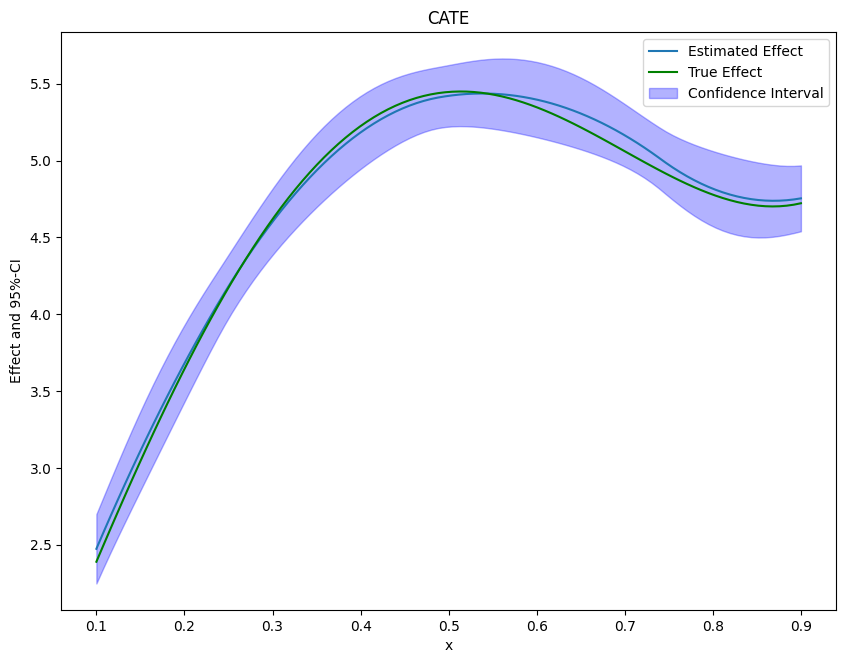

In [8]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10., 7.5

df_cate['x'] = new_data['x']
df_cate['true_effect'] = treatment_effect(new_data["x"].reshape(-1, 1))
fig, ax = plt.subplots()
ax.plot(df_cate['x'],df_cate['effect'], label='Estimated Effect')
ax.plot(df_cate['x'],df_cate['true_effect'], color="green", label='True Effect')
ax.fill_between(df_cate['x'], df_cate['2.5 %'], df_cate['97.5 %'], color='b', alpha=.3, label='Confidence Interval')

plt.legend()
plt.title('CATE')
plt.xlabel('x')
_ =  plt.ylabel('Effect and 95%-CI')

If the effect is not one-dimensional, the estimate still corresponds to the projection of the true effect on the basis functions.

## Two-Dimensional Example

It is also possible to estimate multi-dimensional conditional effects. We will use a similar data generating process but now the effect depends on the first two covariates $X_0$ and $X_1$ and takes the following form
$$
\theta_0(X) = \exp(2X_0) + 3\sin(4X_1).
$$

With the argument ``n_x=2`` we can specify set the effect to be two-dimensional.

In [9]:
data_dict = make_heterogeneous_data(
    n_obs=5000,
    p=10,
    support_size=5,
    n_x=2,
)
treatment_effect = data_dict['treatment_effect']
data = data_dict['data']
print(data.head())

,y,d,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9
0,1.347125,0.226604,0.398619,0.026628,0.839477,0.177093,0.673867,0.357376,0.816065,0.509687,0.324402,0.323871
1,2.027996,-0.206664,0.326927,0.788579,0.711116,0.319214,0.490208,0.076153,0.827500,0.265955,0.889225,0.596797
2,8.295554,1.241654,0.567820,0.162719,0.069535,0.552617,0.467989,0.119683,0.835588,0.417240,0.260458,0.788272
3,1.777455,0.002032,0.913064,0.305963,0.775950,0.652520,0.989728,0.203993,0.960679,0.315272,0.411954,0.358826
4,2.174612,0.346674,0.268451,0.693223,0.589145,0.305692,0.132212,0.317376,0.381231,0.380653,0.357260,0.048723


As univariate example estimate the [PLR Model](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLPLR.html).

In [10]:
data_dml_base = dml.DoubleMLData(
    data,
    y_col='y',
    d_cols='d'
)

In [11]:
# First stage estimation
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
ml_l = RandomForestRegressor(n_estimators=500)
ml_m = RandomForestRegressor(n_estimators=500)

np.random.seed(42)

dml_plr = dml.DoubleMLPLR(data_dml_base,
                          ml_l=ml_l,
                          ml_m=ml_m,
                          n_folds=5)
print("Training PLR Model")
dml_plr.fit()

print(dml_plr.summary)

Training PLR Model
       coef   std err          t  P>|t|     2.5 %   97.5 %
d  4.410357  0.049548  89.011513    0.0  4.313245  4.50747


As above, we will rely on the [patsy](https://patsy.readthedocs.io/en/latest/) package to construct the basis elements.
In the two-dimensional case, we will construct a tensor product of B-splines (for more information see [here](https://patsy.readthedocs.io/en/latest/spline-regression.html#tensor-product-smooths)).

In [12]:
design_matrix = patsy.dmatrix("te(bs(x_0, df=7, degree=3), bs(x_1, df=7, degree=3))", {"x_0": data["X_0"], "x_1": data["X_1"]})
spline_basis = pd.DataFrame(design_matrix)

cate = dml_plr.cate(spline_basis)
print(cate)

================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
        coef   std err          t          P>|t|    [0.025    0.975]
0   2.539945  0.099598  25.501845  6.885648e-135  2.344688  2.735202
1  -2.741737  0.838129  -3.271258   1.078035e-03 -4.384842 -1.098632
2   2.124457  0.854413   2.486453   1.293509e-02  0.449429  3.799485
3   2.651842  0.725527   3.655054   2.597935e-04  1.229487  4.074197
4   1.090729  0.710017   1.536200   1.245532e-01 -0.301220  2.482678
5  -3.279133  0.869612  -3.770800   1.646225e-04 -4.983959 -1.574308
6  -3.799930  0.989875  -3.838797   1.251815e-04 -5.740524 -1.859335
7  -7.770616  0.885637  -8.774040   2.335870e-18 -9.506858 -6.034375
8  -0.549316  0.842386  -0.652096   5.143697e-01 -2.200766  1.102134
9   1.458980  0.881178   1.655717   9.784263e-02 -0.268518  3.186479
10  1.297468  0.727671   1.783042   7.464067e-02 -0.129089  2.724025
11  1.478977  0.758855   1.948958   5.135685e-02 -0.008716  2.96

Finally, we create a new grid to evaluate and plot the effects.

In [13]:
grid_size = 100
x_0 = np.linspace(0.1, 0.9, grid_size)
x_1 = np.linspace(0.1, 0.9, grid_size)
x_0, x_1 = np.meshgrid(x_0, x_1)

new_data = {"x_0": x_0.ravel(), "x_1": x_1.ravel()}

In [14]:
spline_grid = pd.DataFrame(patsy.build_design_matrices([design_matrix.design_info], new_data)[0])
df_cate = cate.confint(spline_grid, joint=True, n_rep_boot=2000)
print(df_cate)

         2.5 %    effect    97.5 %
0     1.301785  1.932838  2.563890
1     1.330036  1.948105  2.566173
2     1.367529  1.969294  2.571060
3     1.411532  1.995629  2.579726
4     1.459316  2.026331  2.593346
...        ...       ...       ...
9995  3.986191  4.761410  5.536629
9996  4.072756  4.890740  5.708723
9997  4.163873  5.017336  5.870800
9998  4.261294  5.140187  6.019080
9999  4.365807  5.258278  6.150749

[10000 rows x 3 columns]


In [15]:
import plotly.graph_objects as go

grid_array = np.array(list(zip(x_0.ravel(), x_1.ravel())))
true_effect = treatment_effect(grid_array).reshape(x_0.shape)
effect = np.asarray(df_cate['effect']).reshape(x_0.shape)
lower_bound = np.asarray(df_cate['2.5 %']).reshape(x_0.shape)
upper_bound = np.asarray(df_cate['97.5 %']).reshape(x_0.shape)

fig = go.Figure(data=[
    go.Surface(x=x_0,
               y=x_1,
               z=true_effect),
    go.Surface(x=x_0,
               y=x_1,
               z=upper_bound, showscale=False, opacity=0.4,colorscale='purp'),
    go.Surface(x=x_0,
               y=x_1,
               z=lower_bound, showscale=False, opacity=0.4,colorscale='purp'),
])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))

fig.update_layout(scene = dict(
                    xaxis_title='X_0',
                    yaxis_title='X_1',
                    zaxis_title='Effect'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()